In [39]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable


In [40]:
train_filename = "./train.csv"
test_filename = "./test.csv"

<h3 style="text-align: center;"><b>Computer Vision BaseLine</b></h3>

This BaseLine contains simple CV methods which allow to solve simple tasks







In [41]:

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# MNIST Dataset


`train.csv` - file with training data

`test.csv` - file with test data (no target here)

In [42]:
dataset = pd.read_csv(train_filename, low_memory=False)
dataset

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


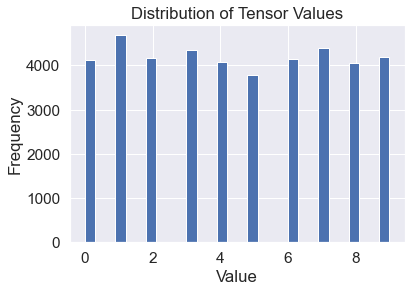

In [43]:
numpy_array = dataset['label'].values

plt.hist(numpy_array, bins=30)
plt.title("Distribution of Tensor Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [44]:
test_size = 0.2
train_data, test_data = train_test_split(dataset, test_size=test_size, random_state=42)

# lets split train dataset on temp_train and test_train
# temp_train will contain training data to train our model
# and temp_test will contain test data with targets to estimate our score
train_data.to_csv("./temp_train.csv", index=False)
test_data.to_csv("./temp_test.csv", index=False)

In [45]:
to_watch_on = pd.read_csv("./temp_train.csv", low_memory=False)
to_watch_on

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33595,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33596,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33597,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33598,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# TARGET should be the first column

picture_height = 28
picture_width = 28

device = "cuda" if torch.cuda.is_available() else "cpu"

class CustomDataset(Dataset):
    def __init__(self, csv_file, is_train: bool, transform=None):
        self.is_train = is_train
        self.data = pd.read_csv(csv_file, low_memory=False)
        self.transform = transform
        print("Downloaded dataset with size: ", self.data.shape)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if (self.is_train):
          features = self.data.iloc[idx, 1:].values.reshape(picture_height, picture_width).astype(np.float32)
          target = torch.tensor(self.data.iloc[idx, 0], dtype=torch.int64)
          target = target.to(device)
        else:
          features = self.data.iloc[idx, 0:].values.reshape(picture_height, picture_width).astype(np.float32)
          target = torch.tensor(-1, dtype=torch.int32)

        if self.transform:
            features = self.transform(features)

        features = features.to(dtype=torch.float32)
        features = features.to(device)

        return features, target


train_dataset = CustomDataset("./temp_train.csv", True, transform=data_tfs)
test_dataset = CustomDataset("./temp_test.csv", True, transform=data_tfs)

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

Downloaded dataset with size:  (33600, 785)
Downloaded dataset with size:  (8400, 785)


In [47]:
device

'cpu'

In [48]:
print("------train-----")
for x, y in train_dataloader:
  print(x.shape)
  print(x.dtype)
  print(y.dtype)
  print(y)
  break
print("------test-----")
for x, y in test_dataloader:
  print(x.shape)
  print(x.dtype)
  print(y)
  break

------train-----
torch.Size([128, 1, 28, 28])
torch.float32
torch.int64
tensor([4, 9, 5, 7, 0, 5, 7, 4, 7, 7, 9, 5, 2, 2, 1, 8, 8, 1, 1, 3, 2, 8, 1, 4,
        4, 5, 8, 3, 1, 2, 1, 8, 0, 6, 7, 6, 9, 9, 2, 3, 0, 3, 9, 3, 8, 2, 3, 0,
        5, 4, 0, 6, 3, 2, 5, 7, 7, 5, 9, 7, 0, 5, 2, 7, 8, 1, 2, 5, 6, 2, 4, 6,
        1, 2, 3, 4, 3, 4, 6, 0, 4, 4, 7, 1, 5, 7, 8, 0, 5, 2, 7, 7, 4, 5, 0, 4,
        7, 0, 0, 8, 1, 9, 5, 0, 2, 1, 1, 4, 0, 2, 9, 5, 9, 4, 9, 1, 1, 0, 9, 4,
        2, 3, 8, 3, 4, 9, 8, 5])
------test-----
torch.Size([128, 1, 28, 28])
torch.float32
tensor([1, 0, 6, 1, 4, 4, 8, 5, 7, 9, 0, 1, 7, 2, 1, 8, 3, 4, 0, 4, 5, 3, 2, 5,
        9, 9, 1, 5, 8, 6, 6, 4, 0, 8, 0, 1, 3, 6, 7, 1, 0, 3, 6, 5, 8, 1, 2, 8,
        7, 0, 0, 5, 8, 7, 8, 1, 4, 2, 4, 3, 4, 9, 3, 8, 5, 2, 4, 2, 0, 1, 2, 2,
        9, 1, 2, 8, 7, 3, 1, 2, 9, 3, 1, 2, 5, 8, 5, 3, 7, 9, 8, 6, 7, 0, 5, 9,
        7, 6, 2, 0, 1, 4, 4, 3, 1, 2, 3, 6, 1, 1, 1, 1, 1, 1, 4, 8, 2, 1, 6, 4,
        4, 8, 4, 3, 5, 8, 9, 5])


## Part 1 - fully-connected neural networks
Lets solve MNIST with FC NN.

### Here is a simple neural network

Lets build simple network with Sequential class. The network itself contains:
* (nn.Flatten);
* Two hidden layers 128 neurons each with nn.ELU activation
* Output layer with 10 neurons

We will use cross-entropy loss function


In [49]:
activation = nn.ELU
features = picture_height * picture_width   # number of flattened array
classes = 10                                # number of classes

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, classes),
    # don't need softmax here!
)
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [50]:
summary(model, (features,), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 128]         100,480
               ELU-3                 [128, 128]               0
            Linear-4                 [128, 128]          16,512
               ELU-5                 [128, 128]               0
            Linear-6                  [128, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.28
Params size (MB): 0.45
Estimated Total Size (MB): 2.11
----------------------------------------------------------------


In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "test": test_dataloader}

### Train loop


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Training process

In [52]:
max_epochs = 10
accuracy = {"train": [], "test": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                  outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all =  batch_size
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.863668893129771
Loader: test. Accuracy: 0.9252403846153846
Epoch: 2
Loader: train. Accuracy: 0.9419429866412213
Loader: test. Accuracy: 0.9346153846153846
Epoch: 3
Loader: train. Accuracy: 0.9518427958015268
Loader: test. Accuracy: 0.940264423076923
Epoch: 4
Loader: train. Accuracy: 0.9641579198473282
Loader: test. Accuracy: 0.9497596153846154
Epoch: 5
Loader: train. Accuracy: 0.9684518129770993
Loader: test. Accuracy: 0.9485576923076923
Epoch: 6
Loader: train. Accuracy: 0.9732824427480916
Loader: test. Accuracy: 0.9474759615384616
Epoch: 7
Loader: train. Accuracy: 0.9725667938931297
Loader: test. Accuracy: 0.9556490384615385
Epoch: 8
Loader: train. Accuracy: 0.9753101145038168
Loader: test. Accuracy: 0.9526442307692308
Epoch: 9
Loader: train. Accuracy: 0.9782621660305344
Loader: test. Accuracy: 0.9568509615384615
Epoch: 10
Loader: train. Accuracy: 0.9795443702290076
Loader: test. Accuracy: 0.9597355769230769


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [58]:
elu_accuracy = accuracy

In [59]:
def test_activation_function(activation):
  print("Testing new activation function: ", activation)
  features = 784  # number of flattened array
  classes = 10    # number of classes

  model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(features, 128),
      activation(),
      nn.Linear(128, 128),
      activation(),
      nn.Linear(128, classes),
      # don't need softmax here!
  )
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  loaders = {"train": train_dataloader, "test": test_dataloader}

  max_epochs = 5
  accuracy = {"train": [], "test": []}
  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
              x_batch = x_batch.to(device)
              y_batch = y_batch.to(device)
              if k == "train":
                  model.train()
                  optimizer.zero_grad()
                  outp = model(x_batch)
              else:
                  model.eval()
                  with torch.no_grad():
                    outp = model(x_batch)
              preds = outp.argmax(-1)
              correct = (preds == y_batch).sum()
              all =  batch_size
              epoch_correct += correct.item()
              epoch_all += all
              if k == "train":
                  loss = criterion(outp, y_batch)
                  loss.backward()
                  optimizer.step()
          if k == "train":
              print(f"Epoch: {epoch+1}")
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)
  return accuracy

In [60]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [61]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)
tanh_accuracy = test_activation_function(nn.Tanh)
sigmoid_accuracy = test_activation_function(nn.Sigmoid)

Testing new activation function:  <class '__main__.Identical'>
Epoch: 1
Loader: train. Accuracy: 0.8440780057251909
Loader: test. Accuracy: 0.8641826923076923
Epoch: 2
Loader: train. Accuracy: 0.8642950858778626
Loader: test. Accuracy: 0.8579326923076923
Epoch: 3
Loader: train. Accuracy: 0.8688871660305344
Loader: test. Accuracy: 0.8600961538461539
Epoch: 4
Loader: train. Accuracy: 0.8745229007633588
Loader: test. Accuracy: 0.8606971153846154
Epoch: 5
Loader: train. Accuracy: 0.885555820610687
Loader: test. Accuracy: 0.8849759615384616
Testing new activation function:  <class 'torch.nn.modules.activation.ReLU'>
Epoch: 1
Loader: train. Accuracy: 0.8784291507633588
Loader: test. Accuracy: 0.9229567307692308
Epoch: 2
Loader: train. Accuracy: 0.9436426526717557
Loader: test. Accuracy: 0.9389423076923077
Epoch: 3
Loader: train. Accuracy: 0.9599236641221374
Loader: test. Accuracy: 0.9432692307692307
Epoch: 4
Loader: train. Accuracy: 0.9673485209923665
Loader: test. Accuracy: 0.95576923076923

### Accuracy
Lets build accuracy/epoch plot for each activation function

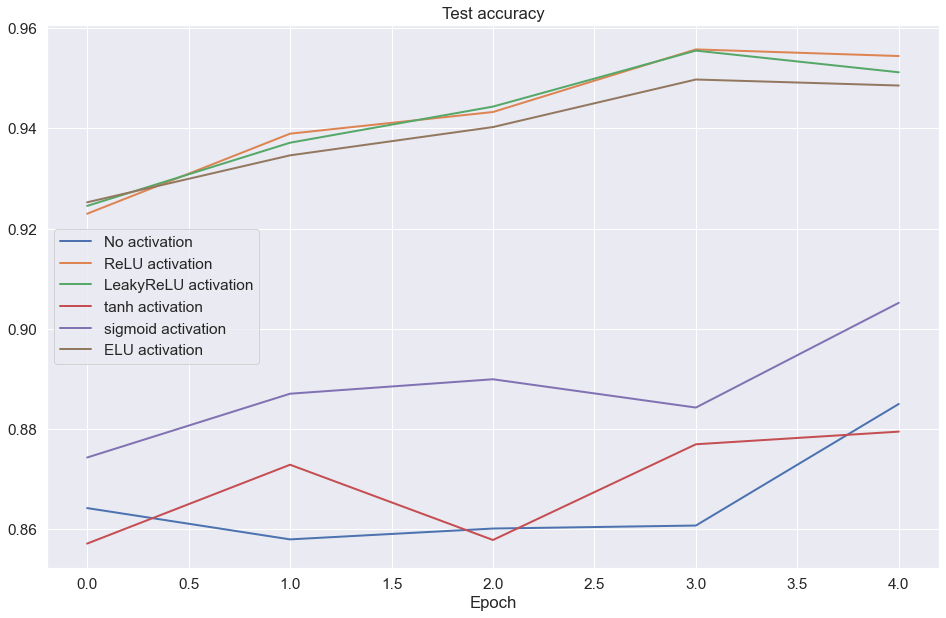

In [62]:
sns.set(style="darkgrid", font_scale=1.4)

x_size = len(relu_accuracy['test'])

plt.figure(figsize=(16, 10))
plt.title("Test accuracy")
plt.plot(range(x_size), plain_accuracy['test'], label="No activation", linewidth=2)
plt.plot(range(x_size), relu_accuracy['test'], label="ReLU activation", linewidth=2)
plt.plot(range(x_size), leaky_relu_accuracy['test'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(x_size), tanh_accuracy['test'], label="tanh activation", linewidth=2)
plt.plot(range(x_size), sigmoid_accuracy['test'], label="sigmoid activation", linewidth=2)
plt.plot(range(x_size), elu_accuracy['test'][:x_size], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

## Part 2 - convolutional neural networks

### LeNet

Convolutional NN shows much better results in CV. Lets use them!

Our CNN has:
* Convilution 3x3 (1 input, 6 output) with ReLU activation
* MaxPooling-а 2x2
* Convilution 3x3 (6 input, 16 output) with ReLU activation
* MaxPooling-а 2x2
* (nn.Flatten)
* Fully-connected layer with 120 neurons and ReLU activation
* Fully-connected layer with 84  neurons and ReLU activation
* Output layer with 10 neurons




In [66]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [67]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "test": test_dataloader}

### CNN training

In [68]:
max_epochs = 10
accuracy = {"train": [], "test": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                  outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all =  batch_size
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8987655057251909
Loader: test. Accuracy: 0.9564903846153846
Epoch: 2
Loader: train. Accuracy: 0.9717616889312977
Loader: test. Accuracy: 0.9742788461538462
Epoch: 3
Loader: train. Accuracy: 0.9808265744274809
Loader: test. Accuracy: 0.9787259615384616
Epoch: 4
Loader: train. Accuracy: 0.9846731870229007
Loader: test. Accuracy: 0.9814903846153846
Epoch: 5
Loader: train. Accuracy: 0.9883110687022901
Loader: test. Accuracy: 0.9770432692307692
Epoch: 6
Loader: train. Accuracy: 0.9899510973282443
Loader: test. Accuracy: 0.9801682692307693
Epoch: 7
Loader: train. Accuracy: 0.9908158396946565
Loader: test. Accuracy: 0.9828125
Epoch: 8
Loader: train. Accuracy: 0.9931416984732825
Loader: test. Accuracy: 0.9829326923076923
Epoch: 9
Loader: train. Accuracy: 0.9931715171755725
Loader: test. Accuracy: 0.9823317307692307
Epoch: 10
Loader: train. Accuracy: 0.9946326335877863
Loader: test. Accuracy: 0.9807692307692307


In [69]:
lenet_accuracy = accuracy

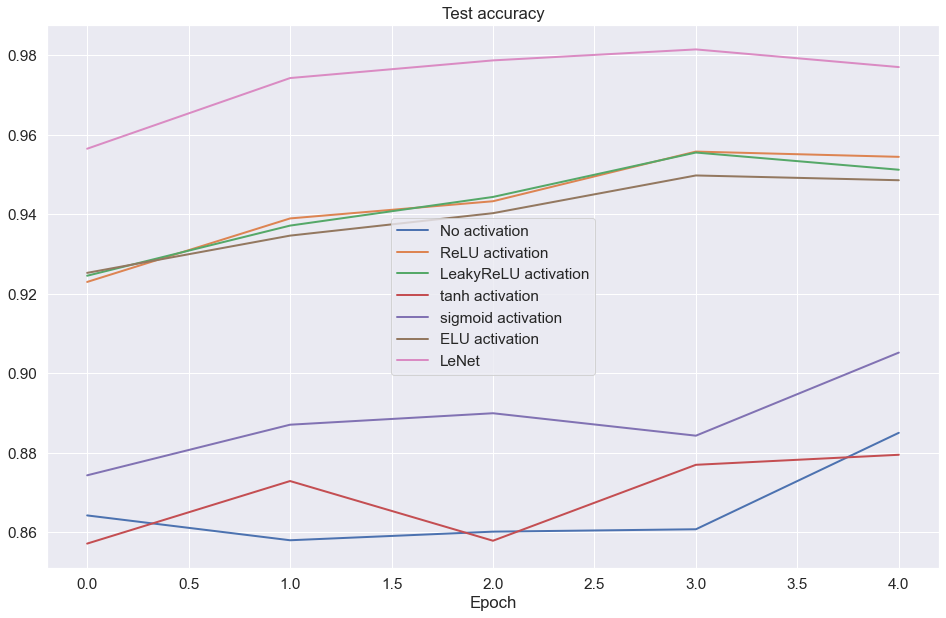

In [70]:
plt.figure(figsize=(16, 10))
plt.title("Test accuracy")
plt.plot(range(x_size), plain_accuracy['test'], label="No activation", linewidth=2)
plt.plot(range(x_size), relu_accuracy['test'], label="ReLU activation", linewidth=2)
plt.plot(range(x_size), leaky_relu_accuracy['test'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(x_size), tanh_accuracy['test'], label="tanh activation", linewidth=2)
plt.plot(range(x_size), sigmoid_accuracy['test'], label="sigmoid activation", linewidth=2)
plt.plot(range(x_size), elu_accuracy['test'][:x_size], label="ELU activation", linewidth=2)
plt.plot(range(x_size), lenet_accuracy['test'][:x_size], label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()



**Result:** `epochs = 10 -> accuracy = 0.988`

# Training on the full dataset


In [71]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

batch_size = 280 # this number should be a divider of test size!!
train_dataset = CustomDataset(train_filename, True, transform=data_tfs)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=2)

loaders = {"train": train_dataloader}
max_epochs = 35
accuracy = {"train": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            model.train()
            optimizer.zero_grad()
            outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all =  batch_size
            epoch_correct += correct.item()
            epoch_all += all
            optimizer.zero_grad()
            loss = criterion(outp, y_batch)
            loss.backward()
            optimizer.step()

        print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Downloaded dataset with size:  (42000, 785)
Epoch: 1
Loader: train. Accuracy: 0.8677380952380952
Epoch: 2
Loader: train. Accuracy: 0.9688809523809524
Epoch: 3
Loader: train. Accuracy: 0.9793809523809524
Epoch: 4
Loader: train. Accuracy: 0.9851666666666666
Epoch: 5
Loader: train. Accuracy: 0.987904761904762
Epoch: 6
Loader: train. Accuracy: 0.9895952380952381
Epoch: 7
Loader: train. Accuracy: 0.9926190476190476
Epoch: 8
Loader: train. Accuracy: 0.9935
Epoch: 9
Loader: train. Accuracy: 0.9943571428571428
Epoch: 10
Loader: train. Accuracy: 0.9950238095238095
Epoch: 11
Loader: train. Accuracy: 0.9945714285714286
Epoch: 12
Loader: train. Accuracy: 0.9955238095238095
Epoch: 13
Loader: train. Accuracy: 0.9962857142857143
Epoch: 14
Loader: train. Accuracy: 0.9961666666666666
Epoch: 15
Loader: train. Accuracy: 0.9962857142857143
Epoch: 16
Loader: train. Accuracy: 0.9979285714285714
Epoch: 17
Loader: train. Accuracy: 0.9955238095238095
Epoch: 18
Loader: train. Accuracy: 0.9958571428571429
Epoch:

In [76]:
real_test_dataset = CustomDataset(test_filename, False, transform=data_tfs)
real_test_dataloader = DataLoader(real_test_dataset, batch_size=batch_size, drop_last=True, num_workers=2)

Downloaded dataset with size:  (28000, 784)


In [77]:
print("------real_test-----")
for x, y in real_test_dataloader:
  print(x.shape)
  print(x.dtype)
  print(y)
  break

------real_test-----
torch.Size([280, 1, 28, 28])
torch.float32
tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

In [79]:
model.eval()
preds = []
total_tests = 0

for x_batch, _ in real_test_dataloader:
    total_tests += len(_)
    x_batch = x_batch.to(device)
    outp = model(x_batch)
    current_preds = outp.argmax(-1)
    preds += current_preds.cpu().tolist()

print("Calculated answers for", total_tests, "rows")

Calculated answers for 28000 rows


In [80]:
pd.DataFrame(preds)

,0
0,2
1,0
2,9
3,9
4,3
...,...
27995,9
27996,7
27997,3
27998,9


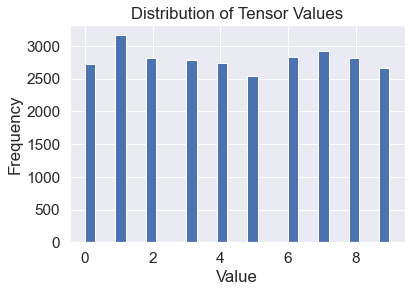

In [81]:
numpy_array = preds

plt.hist(numpy_array, bins=30)
plt.title("Distribution of Tensor Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [82]:
export = pd.DataFrame({'ImageId': range(1, 28001),
                       'Label': preds})

export.to_csv("./answers.csv", index=False)